<a href="https://colab.research.google.com/github/YichengShen/segment-anything/blob/main/testing/SAM%E5%9C%A8KSDD%E6%95%B0%E6%8D%AE%E9%9B%86%E4%B8%8A%E7%9A%84%E6%95%88%E6%9E%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 测试SAM对KSDD数据集（表面缺陷检测）的效果

## 环境设置

*   要求 `python>=3.8， pytorch>=1.7， torchvision>=0.8`
*   需要下载模型checkpoint(大约2.4G)



In [3]:
using_colab = True

In [4]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
        
    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.0.1+cu118
Torchvision version: 0.15.2+cu118
CUDA is available: True
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-4jlohmg9
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-4jlohmg9
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36589 sha256=8b636bb3e3f2fa3d252db13bfb618eec0cd154d112187438963aa544a247dbcb
  Stored in directory: /tmp/pip-ephem-wheel-cache-four3yxg/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segm

## 包、辅助函数

In [5]:
import os
import random
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import urllib.request

In [6]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

##下载KSDD数据集

In [1]:
!wget -O ksdd.zip https://go.vicos.si/kolektorsdd2

--2023-06-09 19:33:31--  https://go.vicos.si/kolektorsdd2
Resolving go.vicos.si (go.vicos.si)... 212.235.189.18
Connecting to go.vicos.si (go.vicos.si)|212.235.189.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://box.vicos.si/skokec/gostop/KolektorSDD2.zip [following]
--2023-06-09 19:33:32--  https://box.vicos.si/skokec/gostop/KolektorSDD2.zip
Resolving box.vicos.si (box.vicos.si)... 212.235.189.20
Connecting to box.vicos.si (box.vicos.si)|212.235.189.20|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 853126555 (814M) [application/zip]
Saving to: ‘ksdd.zip’

ksdd.zip            100%[===================>] 813.60M  23.1MB/s    in 37s     

2023-06-09 19:34:09 (22.1 MB/s) - ‘ksdd.zip’ saved [853126555/853126555]



In [2]:
!mkdir data
!unzip -q /content/ksdd.zip -d /content/data
!rm /content/ksdd.zip

## 测试

In [7]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

In [20]:
def segment_and_plot(folder_path, image_fname, ground_truth_fname, mask_generator):
    plt.figure(figsize=(6,12))

    image = cv2.imread(os.path.join(folder_path, image_fname))
    # three_channel_image = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2BGR)

    masks = mask_generator.generate(image)
    print(f"{image_fname}的掩码数量：", len(masks))

    # Plot the grayscale image
    plt.subplot(3, 3, 1) 
    plt.imshow(image, cmap='gray')
    plt.axis('off')

    # Plot the image with masks
    plt.subplot(3, 3, 2)
    plt.imshow(image, cmap='gray')
    show_anns(masks)
    plt.axis('off')

    plt.subplot(3, 3, 3) 
    ground_truth = cv2.imread(os.path.join(folder_path, ground_truth_fname), cv2.IMREAD_GRAYSCALE)
    plt.imshow(ground_truth, cmap='gray')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    return None

10135.png的掩码数量： 10


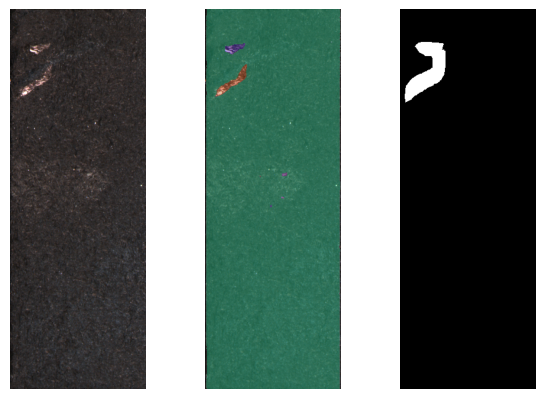

In [21]:
folder_path = "/content/data/train"
image_fname = "10135.png"
ground_truth_fname = "10135_GT.png"

mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.9,
    stability_score_thresh=0.95,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100, 
)

segment_and_plot(folder_path, image_fname, ground_truth_fname, mask_generator)

10159.png的掩码数量： 23


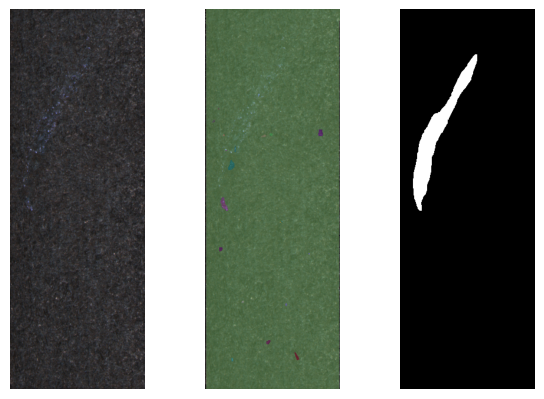

In [23]:
folder_path = "/content/data/train"
image_fname = "10159.png"
ground_truth_fname = "10159_GT.png"
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.85,
    stability_score_thresh=0.85,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100, 
)

segment_and_plot(folder_path, image_fname, ground_truth_fname, mask_generator)

10247.png的掩码数量： 9


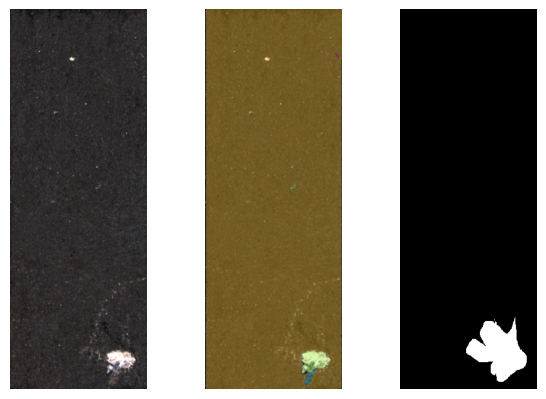

In [26]:
folder_path = "/content/data/train"
image_fname = "10247.png"
ground_truth_fname = "10247_GT.png"
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.92,
    stability_score_thresh=0.95,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100, 
)

segment_and_plot(folder_path, image_fname, ground_truth_fname, mask_generator)

10258.png的掩码数量： 19


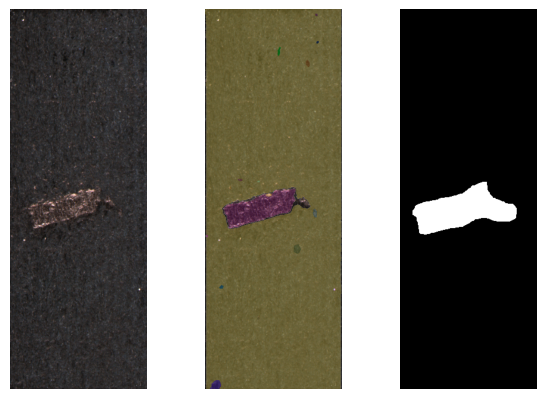

In [28]:
folder_path = "/content/data/train"
image_fname = "10258.png"
ground_truth_fname = "10258_GT.png"
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.9,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100, 
)

segment_and_plot(folder_path, image_fname, ground_truth_fname, mask_generator)

10585.png的掩码数量： 8


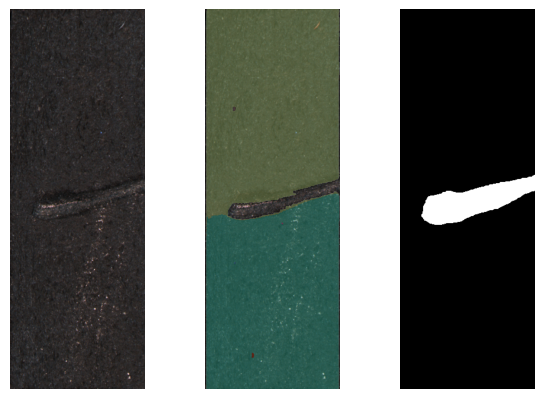

In [30]:
folder_path = "/content/data/train"
image_fname = "10585.png"
ground_truth_fname = "10585_GT.png"
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.92,
    stability_score_thresh=0.95,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100, 
)

segment_and_plot(folder_path, image_fname, ground_truth_fname, mask_generator)

12179.png的掩码数量： 3


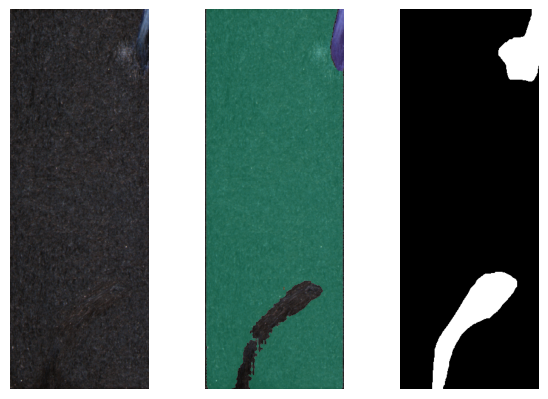

In [32]:
folder_path = "/content/data/train"
image_fname = "12179.png"
ground_truth_fname = "12179_GT.png"
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.90,
    stability_score_thresh=0.95,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100, 
)

segment_and_plot(folder_path, image_fname, ground_truth_fname, mask_generator)